In [1]:
nevecs = 60
ncomps = 500
nbasecomps = 20
crop_size=180
ncauses = 2
dr_method = 'PCA'

In [2]:
from pathlib import Path
import os, sys
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

exp_name = 'far_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

val_csv_path = macaw_path/'splits'/'val.csv'
val_img_path = macaw_path/exp_name/'val'

pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'

train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
val_path = macaw_path/exp_name/f'val_hc_data_PCA_{ncomps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [4]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease_t = train['disease']
bias_t = train['bias']

encoded_t = train['encoded_data']
pca_t = train['pca']

In [5]:
with open(val_path, 'rb') as f:
    val = pickle.load(f)
    
disease_v = val['disease']
bias_v = val['bias']

encoded_v = val['encoded_data']
pca_v = val['pca']

In [6]:
encoded_t.shape

(1005, 500)

In [7]:
encoded_v.shape

(1005, 500)

In [8]:
bias_t.sum()

505

In [9]:
bias_v.sum()

505

In [10]:
disease_t.sum()

500

In [11]:
disease_v.sum()

500

## Causal Graph

In [12]:
disease_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]

bias_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]

autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = [(i,j) for i in range(ncauses,2*ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = []
edges = disease_to_latents + bias_to_latents + autoregressive_latents

## Priors

In [13]:
P_bias = np.sum(bias_t)/len(bias_t)
print(P_bias)

P_dis = np.sum(disease_t)/len(disease_t)
print(P_dis)

0.5024875621890548
0.4975124378109453


In [14]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
config.device

device(type='cuda')

In [16]:
import torch.distributions as td

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_bias]).to(torch.device(config.device)))), # bias
          (slice(1,2),td.Bernoulli(torch.tensor([P_dis]).to(torch.device(config.device)))), # disease
          (slice(nbasecomps+2,nevecs+2),td.Normal(torch.zeros(nevecs-nbasecomps).to(torch.device(config.device)), torch.ones(nevecs-nbasecomps).to(torch.device(config.device)))), # new_comps
         ]

In [17]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2024-06-05 11:19:29.773822: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 11:19:29.774869: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 11:19:29.799244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 11:19:30.321440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
loss_vals = []

In [19]:
from macaw import MACAW

for e in range(0,479,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed_t = encoded_t[:,e:e+nevecs]
    ed_v = encoded_v[:,e:e+nevecs]
    print(e,e+nevecs)
    
    if os.path.exists(save_path): 
       
        X = np.hstack([bias_t[:,np.newaxis], disease_t[:,np.newaxis], ed_t])   
        Y = np.hstack([bias_v[:,np.newaxis], disease_v[:,np.newaxis], ed_v])   

        macaw = MACAW.MACAW(config)
        loss_vals.append(macaw.fit_with_priors(X, Y, edges, priors))

        torch.save(macaw,save_path)
    else:
        print("Skipping")

0 60


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 17
40 100


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 22
80 140


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 22
120 180


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 24
160 220


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 22
200 260


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 27
240 300


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 24
280 340


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 24
320 380


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 24
360 420


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 25
400 460


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 24
440 500


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at epoch 23


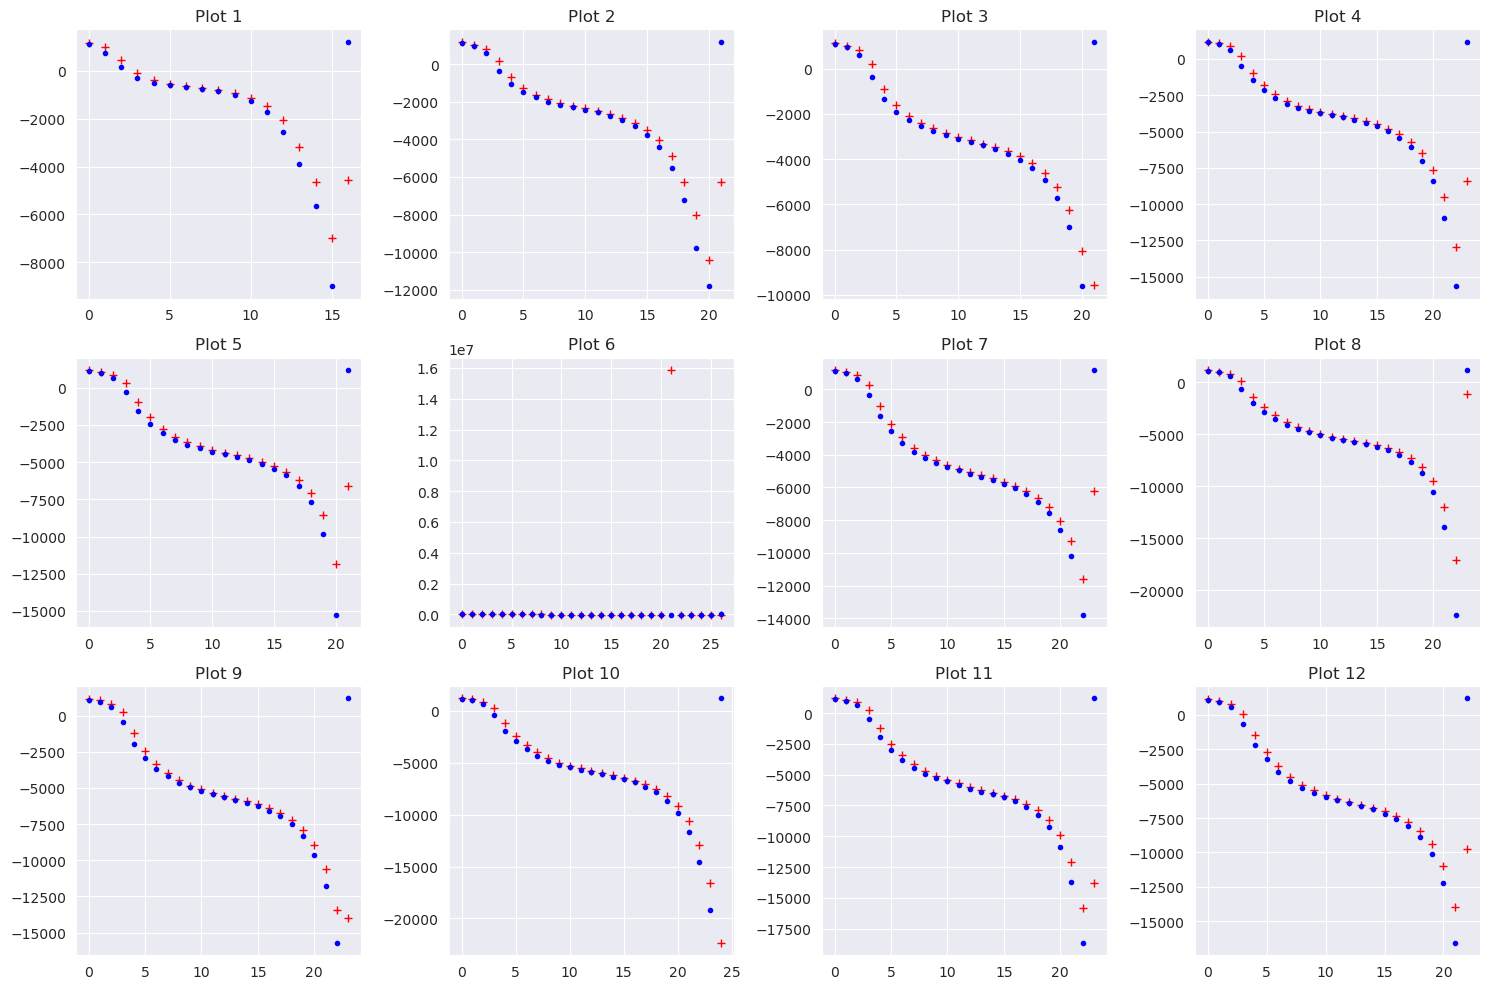

In [20]:
# Set up a grid with 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each loss value in the grid
for i in range(len(loss_vals)):
    axs[i].plot(np.array(loss_vals[i][0]), 'r+')
    axs[i].plot(np.array(loss_vals[i][1]), 'b.')
    axs[i].set_title(f'Plot {i+1}')

# Hide any empty subplots (in this case, the 12th subplot)
for i in range(len(loss_vals), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [21]:
# for i in range(len(loss_vals)):
#     plt.figure(i)  # Create a new figure for each plot
#     plt.plot(np.array(loss_vals[i][0]), 'r+')
#     plt.plot(np.array(loss_vals[i][1]), 'b.')
#     plt.show()  # Display the plot

In [22]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size}, f)